In [1]:
import os

import anndata
import cooler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

In [2]:
cools_path = '/lmh_data/data/sclab/Lee2019/Human_single_cell_10kb_cool'

map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
rna_marker_gene = pd.read_csv('/lmh_data/data/sclab/sclab/rna_marker_gene.csv', sep='\t', index_col=0)

rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})

In [3]:
map_info

,scHiC,cell_type
AAACCCACAGTGAGCA-LKTX_190129_01_A01,190305_29yr_2_F2_AD012_ODC,ODC
AAAGGTATCGGCTGGT-LKTX_190129_01_A01,181218_21yr_3_H5_AD007_ODC,ODC
AATCACGAGAGTCCGA-LKTX_190129_01_A01,190305_21yr_2_E12_AD008_ODC,ODC
AATCGACGTGAGCCAA-LKTX_190129_01_A01,190315_29yr_6_C7_AD002_ODC,ODC
AATGGAAAGTCGAGGT-LKTX_190129_01_A01,190315_21yr_6_A5_AD012_ODC,ODC
...,...,...
ACGTTCCAGTGAACAT-LKTX_190130_01_H01,190315_21yr_6_B11_AD008_Endo,Endo
GAGAAATGTCTCAGGC-LKTX_190130_01_H01,181218_21yr_2_E4_AD004_Endo,Endo
GATTCTTTCTTCCTAA-LKTX_190130_01_H01,190305_29yr_2_E8_AD012_Endo,Endo
GTCGCGAGTGAGAGGG-LKTX_190130_01_H01,181218_21yr_3_A5_AD008_Endo,Endo


In [4]:
rna_marker_gene

,rank,chrom,chromStart,chromEnd,strand
A2M,['Endo_13'],chr12,9220259.0,9268825.0,-
ABCA8,['ODC_84'],chr17,66863432.0,66951533.0,-
ABCB1,['Endo_0'],chr7,87133174.0,87342611.0,-
ABCG2,['Endo_12'],chr4,89011415.0,89152474.0,-
ABLIM1,['Astro_40'],chr10,116190871.0,116444762.0,-
...,...,...,...,...,...
ZNF385D,['Pvalb_20'],chr3,21459914.0,22414812.0,-
ZNF462,['OPC_87'],chr9,109625377.0,109775915.0,+
ZNF804A,['Pvalb_12'],chr2,185463092.0,185804219.0,+
ZNRF3,['Astro_57'],chr22,29279579.0,29453475.0,+


In [5]:
Astro_map_info = map_info[map_info['cell_type']=='Astro']
scRNA, scHiC = Astro_map_info.index, Astro_map_info['scHiC']
scHiC

AAGACTCAGGGAACAA-LKTX_190129_01_A01    190305_29yr_2_F12_AD002_Astro
ACCCAAACAAGAGGCT-LKTX_190129_01_A01    190305_29yr_2_D12_AD002_Astro
AGTACTGCAGATGCGA-LKTX_190129_01_A01     190315_29yr_4_E6_AD001_Astro
ATCGATGTCTGCGATA-LKTX_190129_01_A01     190315_29yr_4_H5_AD002_Astro
ATTTCACTCCGTGTGG-LKTX_190129_01_A01     190315_29yr_6_E6_AD007_Astro
                                                   ...              
TGTTACTCACAGTGAG-LKTX_190130_01_H01     190315_29yr_6_F5_AD007_Astro
TGTTCTAGTAGTGATA-LKTX_190130_01_H01     190315_21yr_6_D4_AD004_Astro
TTACAGGAGGAACATT-LKTX_190130_01_H01     190305_21yr_2_F4_AD006_Astro
TTCAGGATCGTGGGTC-LKTX_190130_01_H01     190305_29yr_2_B3_AD010_Astro
TTGTTTGAGGTCTGGA-LKTX_190130_01_H01     190315_21yr_4_C6_AD002_Astro
Name: scHiC, Length: 525, dtype: object

In [6]:
def catch_location(filename: str, chrom: str, start: int, end: int, strand: str, ignore_diag=True):
    _path = os.path.join(cools_path, filename)
    _c = cooler.Cooler(_path)
    if strand == '+':
        start -= 5000
    else:
        end += 5000
#     contact = _c.pixels(join=True).fetch('{}:{}-{}'.format(chrom, start, end))
    contact = _c.matrix(balance=False, as_pixels=True, join=True).fetch('{}:{}-{}'.format(chrom, start, end))
    mat = _c.matrix(balance=False).fetch('{}:{}-{}'.format(chrom, start, end))
    
    if ignore_diag:
        np.fill_diagonal(mat, 0)
    return contact, mat

def catch_locations(cell_type, chrom: str, start: int, end: int, strand: str):
    _result = None
    scHiC = map_info[map_info['cell_type']==cell_type]['scHiC'][:60]
    for i in tqdm.tqdm(scHiC, desc='scHiC'):
        contact, mat = catch_location('{}_10kb_contacts.cool'.format(i), chrom, start, end, strand)
        _result = _result + mat if _result is not None else mat
    _result = _result / len(scHiC)

    
    fig = plt.figure(figsize=[7, 7])
    ax = fig.add_subplot()
    ax.set_title('{}:{}-{}.{}.{}'.format(chrom, start, end, strand, cell_type))
    sns.heatmap(_result, cmap='Reds_r', square=True)
    return

def test(gene_name):
    _loc = rna_marker_gene.loc[gene_name]
    print(_loc)
    for cell_type in ['Astro', 'Endo', 'ODC', 'OPC']:
        catch_locations(cell_type, _loc['chrom'], int(_loc['chromStart']), int(_loc['chromEnd']), _loc['strand'])

rank          ['Astro_0']
chrom               chr13
chromStart     92050928.0
chromEnd       93519490.0
strand                  +
Name: GPC5, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 44.99it/s]


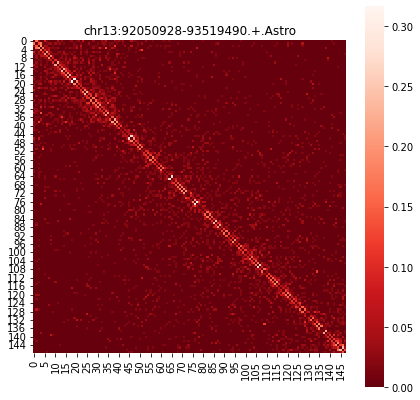

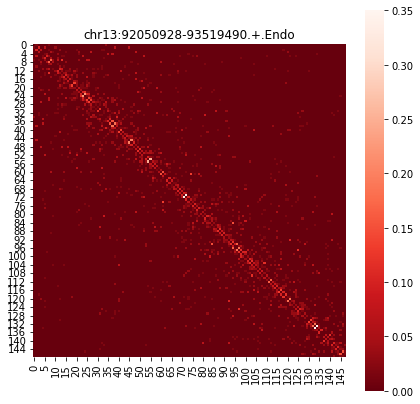

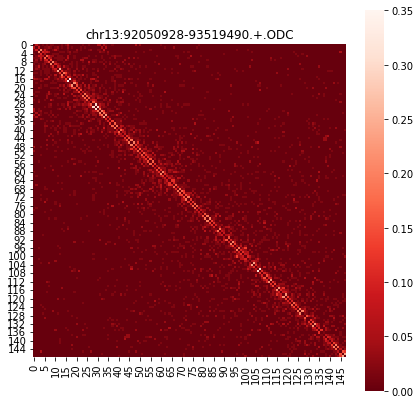

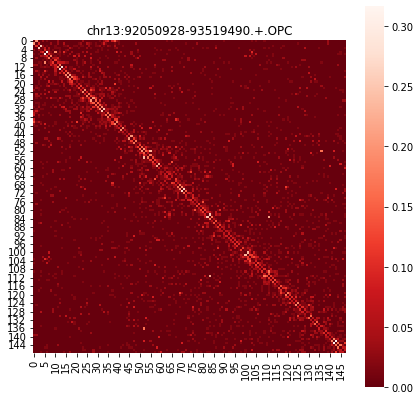

In [7]:
test('GPC5')

rank          ['Astro_1', 'Sst_42', 'OPC_56']
chrom                                    chr4
chromStart                        176554084.0
chromEnd                          176923815.0
strand                                      -
Name: GPM6A, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.06it/s]


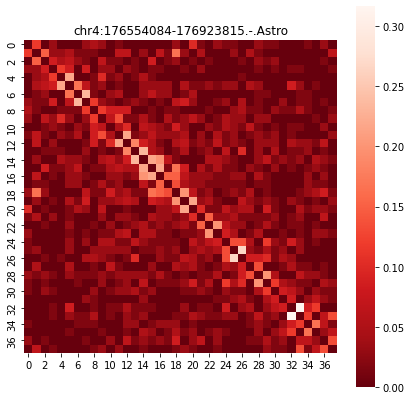

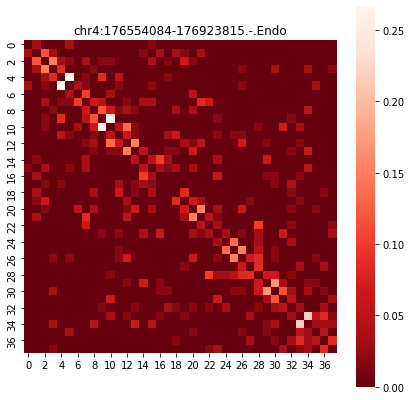

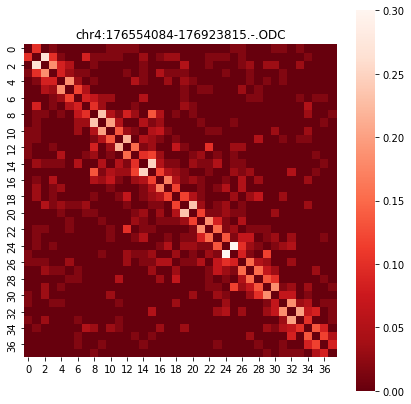

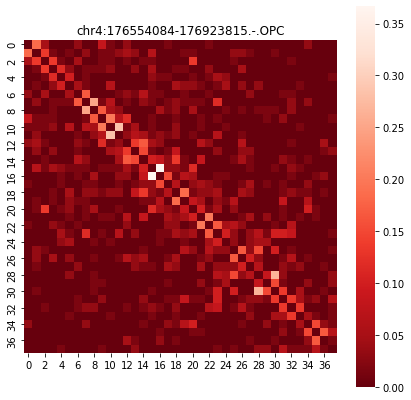

In [8]:
test('GPM6A')

rank          ['Endo_0']
chrom               chr7
chromStart    87133174.0
chromEnd      87342611.0
strand                 -
Name: ABCB1, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 51.06it/s]


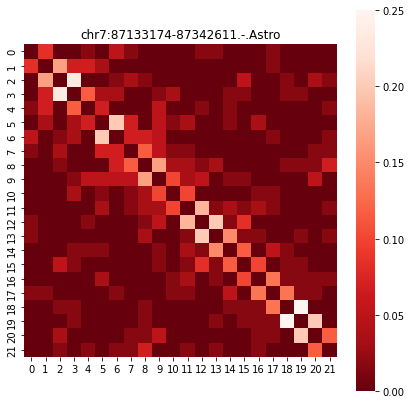

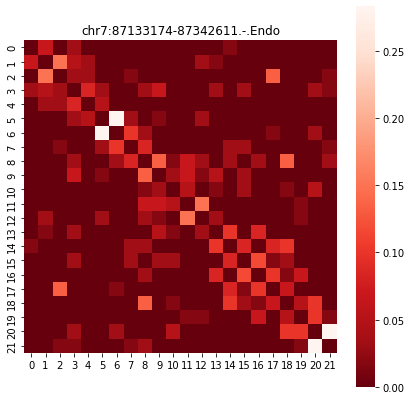

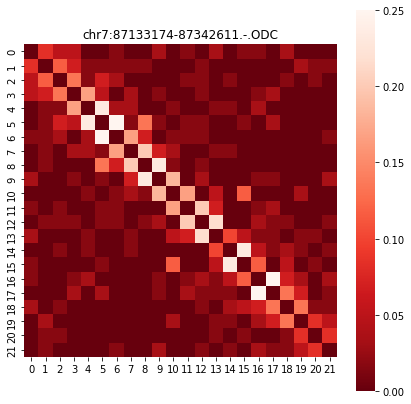

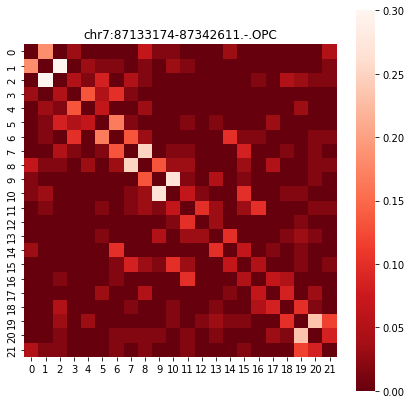

In [9]:
test('ABCB1')

rank           ['Endo_1']
chrom                chr6
chromStart    144606836.0
chromEnd      145174170.0
strand                  +
Name: UTRN, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.83it/s]


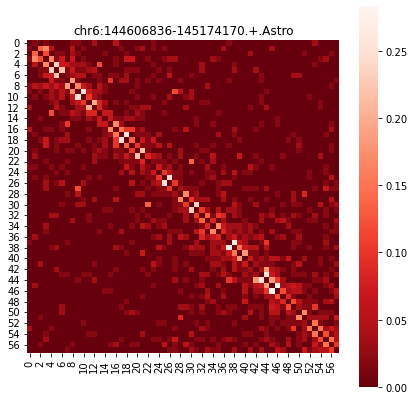

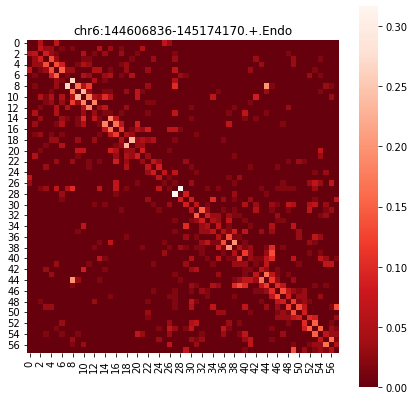

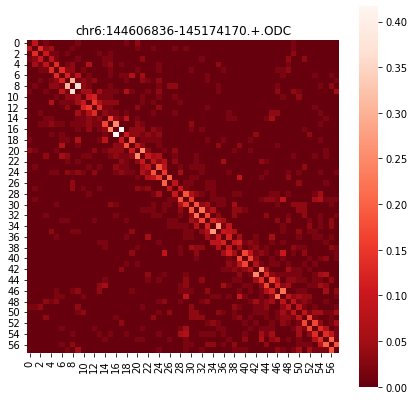

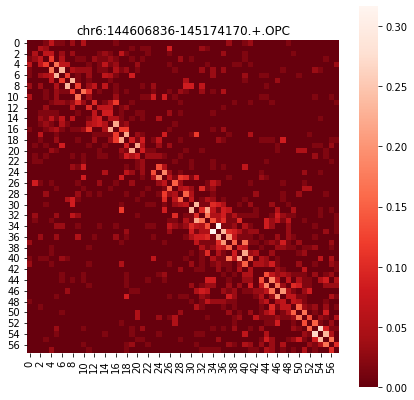

In [10]:
test('UTRN')

rank           ['ODC_0']
chrom              chr10
chromStart    67672275.0
chromEnd      69455927.0
strand                 -
Name: CTNNA3, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.88it/s]


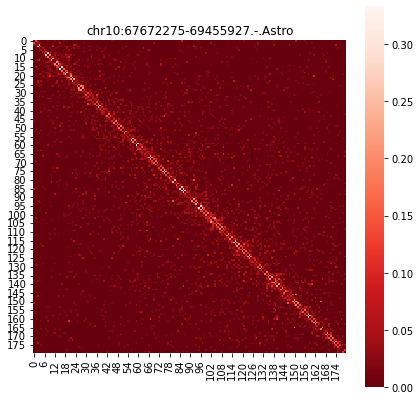

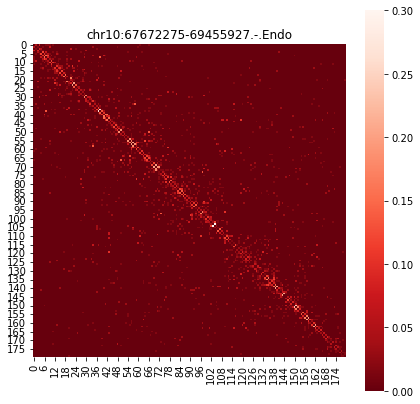

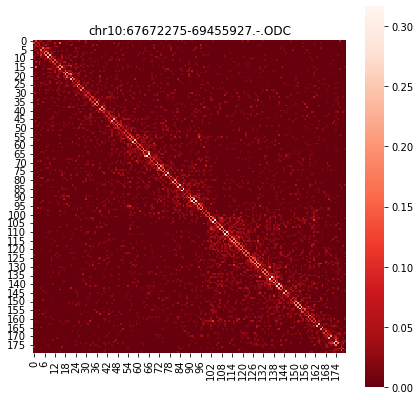

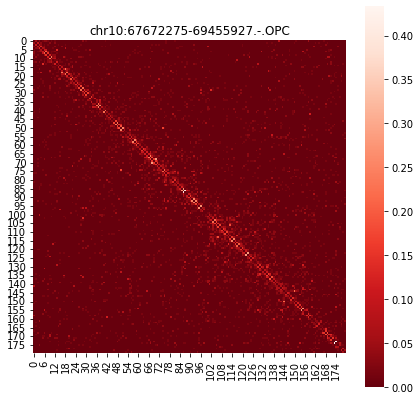

In [11]:
test('CTNNA3')

rank           ['ODC_1']
chrom               chr8
chromStart    53023398.0
chromEnd      53373519.0
strand                 -
Name: ST18, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.81it/s]


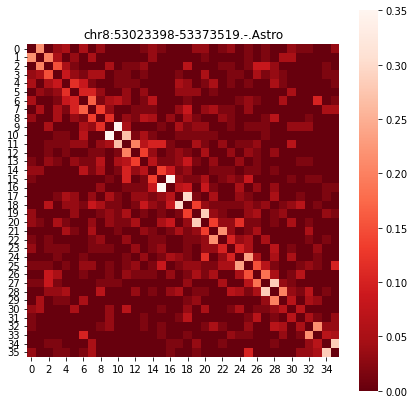

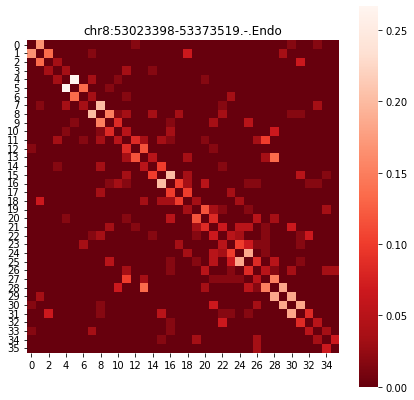

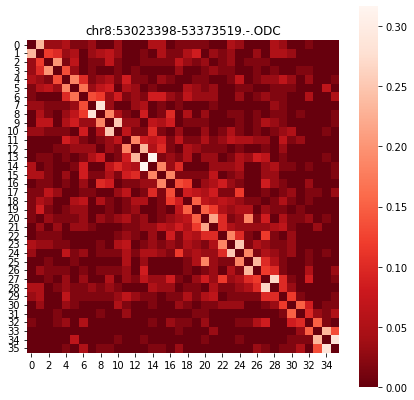

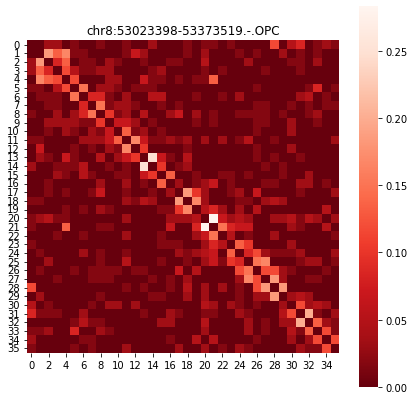

In [12]:
test('ST18')

rank          ['OPC_0', 'Astro_41']
chrom                          chr7
chromStart              121513142.0
chromEnd                121702090.0
strand                            +
Name: PTPRZ1, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.91it/s]


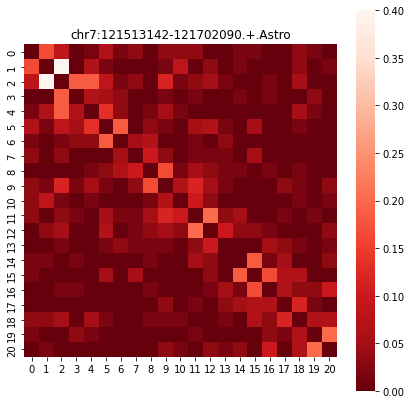

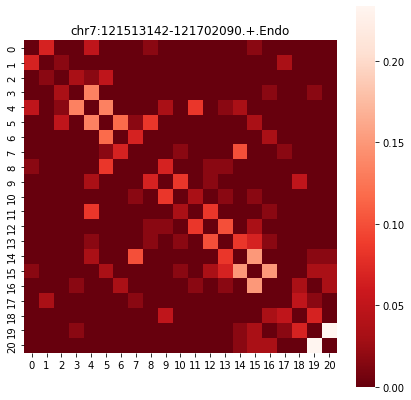

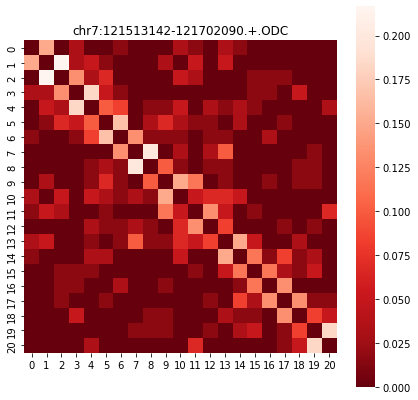

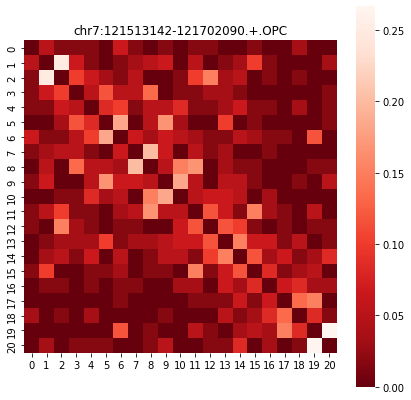

In [13]:
test('PTPRZ1')

rank           ['OPC_1']
chrom              chr10
chromStart    55562530.0
chromEnd      57387702.0
strand                 -
Name: PCDH15, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.67it/s]


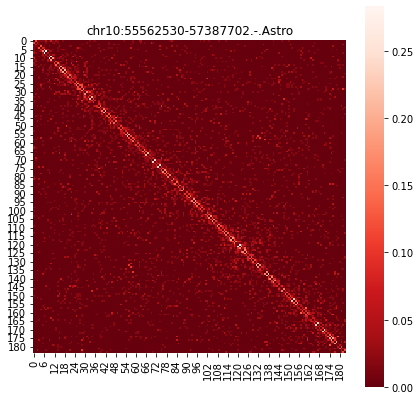

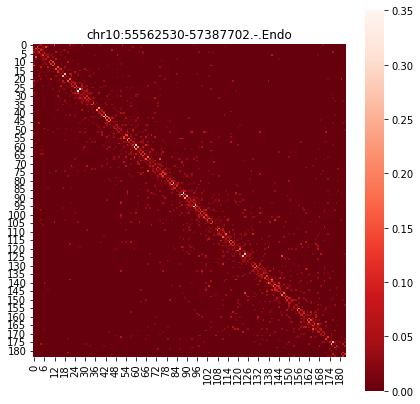

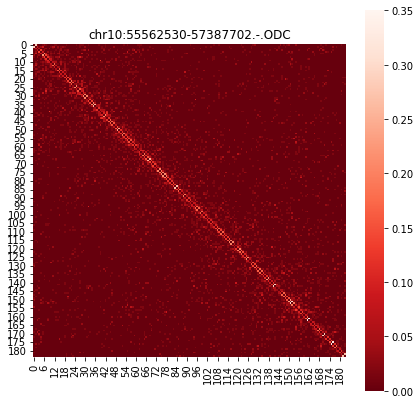

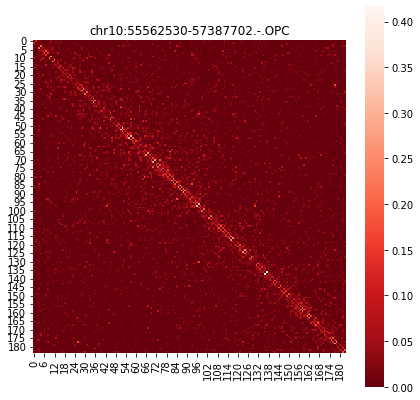

In [14]:
test('PCDH15')

In [15]:
dump_out_dir = '/lmh_data/data/sclab/sclab/partial'

def dump_file(gene_name):
    _loc = rna_marker_gene.loc[gene_name]
    for i in tqdm.tqdm(map_info['scHiC'], desc='scHiC'):
        contact, mat = catch_location(
            '{}_10kb_contacts.cool'.format(i),
            _loc['chrom'], int(_loc['chromStart']), int(_loc['chromEnd']), _loc['strand'])
        
        contact = contact[['chrom1', 'chrom2', 'start1', 'end1', 'start2', 'end2', 'count']]
#         contact = contact[contact['chrom1']==contact['chrom2']]
        contact['chrom1'] = contact['chrom1'].str[3:]
        contact['chrom2'] = contact['chrom2'].str[3:]
        contact.rename(columns={'chrom1':'chr1', 'chrom2':'chr2'}, inplace=True)
        
        outdir = os.path.join(dump_out_dir, gene_name)
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        contact.to_csv(os.path.join(outdir, i), sep="\t", index=False, header=True)
    return

In [16]:
dump_file('GPC5')
dump_file('GPM6A')
dump_file('ABCB1')
dump_file('UTRN')
dump_file('CTNNA3')
dump_file('ST18')
dump_file('PTPRZ1')
dump_file('PCDH15')

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3063/3063 [01:17<00:00, 39.67it/s]


In [17]:
map_info[map_info['scHiC']=='190315_29yr_6_D11_AD004_Endo']

,scHiC,cell_type
CCGGACATCTAGCCTC-LKTX_190129_01_D01,190315_29yr_6_D11_AD004_Endo,Endo
ACTTTCATCAGACCCG-LKTX_190130_01_F01,190315_29yr_6_D11_AD004_Endo,Endo


<AxesSubplot:>

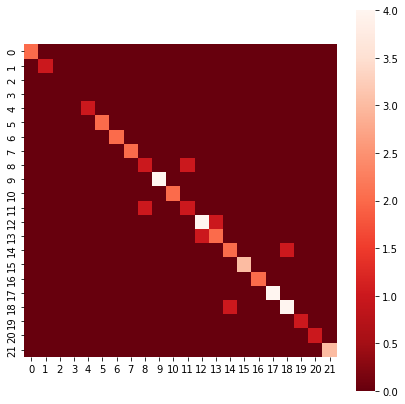

In [18]:
_loc = rna_marker_gene.loc['ABCB1']

chrom, start, end, strand = _loc['chrom'], int(_loc['chromStart']), int(_loc['chromEnd']), _loc['strand']
contact, mat = catch_location('190315_29yr_6_D11_AD004_Endo_10kb_contacts.cool', chrom, start, end, strand, False)

fig = plt.figure(figsize=[7, 7])
ax = fig.add_subplot()
# ax.set_title('{}:{}-{}.{}.{}'.format(chrom, start, end, strand, cell_type))
sns.heatmap(mat, cmap='Reds_r', square=True)

<AxesSubplot:>

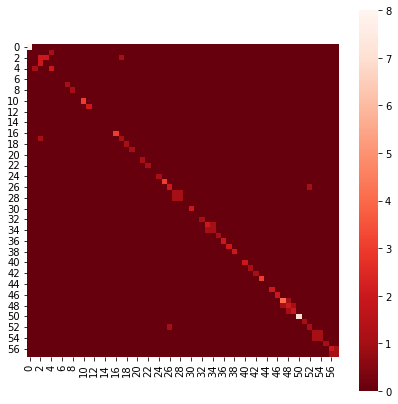

In [19]:
_loc = rna_marker_gene.loc['UTRN']

chrom, start, end, strand = _loc['chrom'], int(_loc['chromStart']), int(_loc['chromEnd']), _loc['strand']
contact, mat = catch_location('190315_29yr_6_D11_AD004_Endo_10kb_contacts.cool', chrom, start, end, strand, False)

fig = plt.figure(figsize=[7, 7])
ax = fig.add_subplot()
# ax.set_title('{}:{}-{}.{}.{}'.format(chrom, start, end, strand, cell_type))
sns.heatmap(mat, cmap='Reds_r', square=True)

In [20]:
rna[['CCGGACATCTAGCCTC-LKTX_190129_01_D01', 'ACTTTCATCAGACCCG-LKTX_190130_01_F01'], ['ABCB1', 'UTRN']].X

ArrayView([[ 8.,  7.],
           [23.,  3.]], dtype=float32)

In [21]:
rna[map_info[map_info['cell_type']=='Endo'].index, 'ABCB1'].X.mean()

ArrayView(9.714286, dtype=float32)

In [22]:
rna[map_info[map_info['cell_type']=='Endo'].index, 'UTRN'].X.mean()

ArrayView(5.0793653, dtype=float32)

In [23]:
map_info[map_info['scHiC']=='181218_21yr_2_B10_AD008_Endo']

,scHiC,cell_type
ATGCGATTCGGAGTGA-LKTX_190129_01_E01,181218_21yr_2_B10_AD008_Endo,Endo
ATAGACCCAGCTTCGG-LKTX_190130_01_A01,181218_21yr_2_B10_AD008_Endo,Endo


<AxesSubplot:>

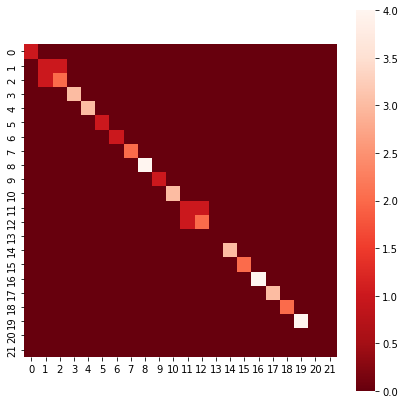

In [24]:
_loc = rna_marker_gene.loc['ABCB1']

chrom, start, end, strand = _loc['chrom'], int(_loc['chromStart']), int(_loc['chromEnd']), _loc['strand']
contact, mat = catch_location('181218_21yr_2_B10_AD008_Endo_10kb_contacts.cool', chrom, start, end, strand, False)

fig = plt.figure(figsize=[7, 7])
ax = fig.add_subplot()
# ax.set_title('{}:{}-{}.{}.{}'.format(chrom, start, end, strand, cell_type))
sns.heatmap(mat, cmap='Reds_r', square=True)

<AxesSubplot:>

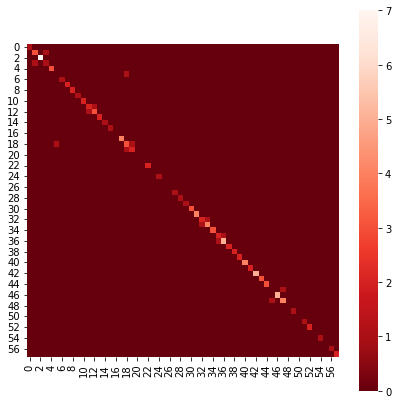

In [25]:
_loc = rna_marker_gene.loc['UTRN']

chrom, start, end, strand = _loc['chrom'], int(_loc['chromStart']), int(_loc['chromEnd']), _loc['strand']
contact, mat = catch_location('181218_21yr_2_B10_AD008_Endo_10kb_contacts.cool', chrom, start, end, strand, False)

fig = plt.figure(figsize=[7, 7])
ax = fig.add_subplot()
# ax.set_title('{}:{}-{}.{}.{}'.format(chrom, start, end, strand, cell_type))
sns.heatmap(mat, cmap='Reds_r', square=True)

In [26]:
rna[['ATGCGATTCGGAGTGA-LKTX_190129_01_E01', 'ATAGACCCAGCTTCGG-LKTX_190130_01_A01'], ['ABCB1', 'UTRN']].X

ArrayView([[16.,  7.],
           [15.,  2.]], dtype=float32)

In [27]:
map_info[map_info['scHiC']=='181218_21yr_2_D7_AD002_Endo']

,scHiC,cell_type
AATCACGCAACACACT-LKTX_190129_01_C01,181218_21yr_2_D7_AD002_Endo,Endo
ACTTTCAAGGCACTAG-LKTX_190130_01_E01,181218_21yr_2_D7_AD002_Endo,Endo
AACAAAGGTGCGTTTA-LKTX_190130_01_G01,181218_21yr_2_D7_AD002_Endo,Endo


In [28]:
rna[map_info[map_info['scHiC']=='181218_21yr_2_D7_AD002_Endo'].index, ['ABCB1', 'UTRN']].X

ArrayView([[14.,  6.],
           [18., 11.],
           [ 6.,  8.]], dtype=float32)

<AxesSubplot:>

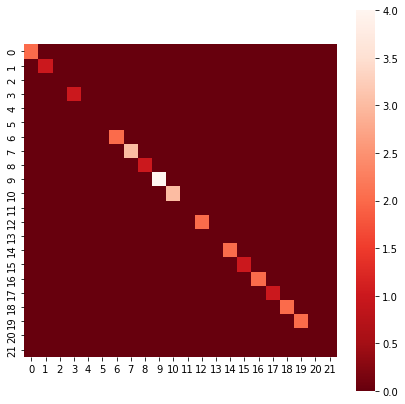

In [29]:
_loc = rna_marker_gene.loc['ABCB1']

chrom, start, end, strand = _loc['chrom'], int(_loc['chromStart']), int(_loc['chromEnd']), _loc['strand']
contact, mat = catch_location('181218_21yr_2_D7_AD002_Endo_10kb_contacts.cool', chrom, start, end, strand, False)

fig = plt.figure(figsize=[7, 7])
ax = fig.add_subplot()
# ax.set_title('{}:{}-{}.{}.{}'.format(chrom, start, end, strand, cell_type))
sns.heatmap(mat, cmap='Reds_r', square=True)

/tmp/ipykernel_1026308/1497756244.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=[7, 7])


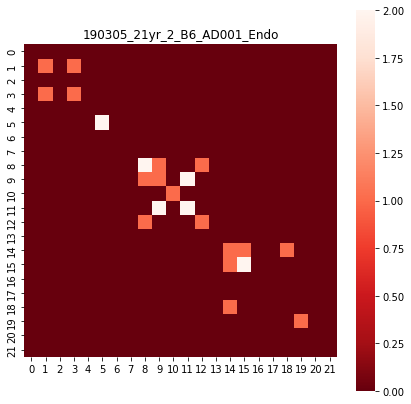

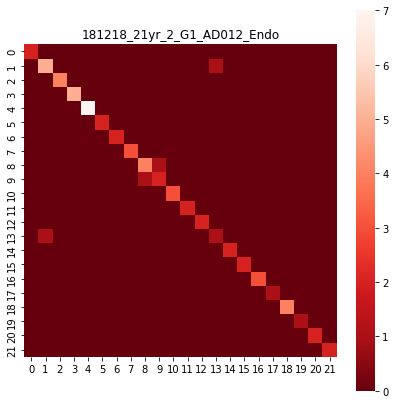

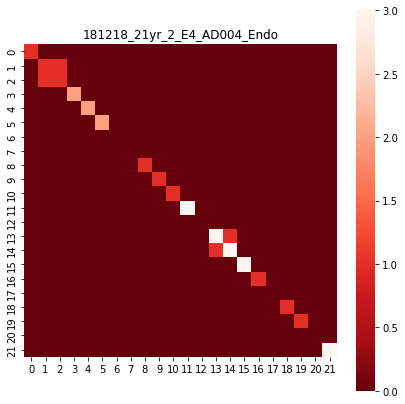

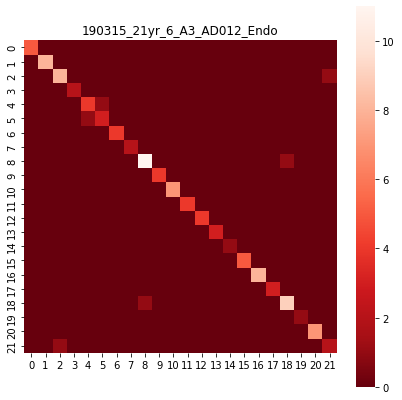

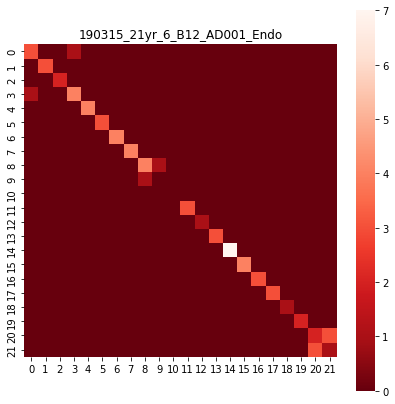

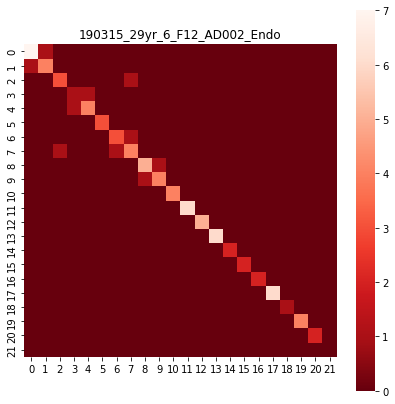

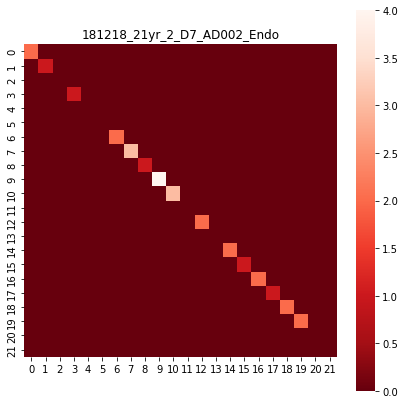

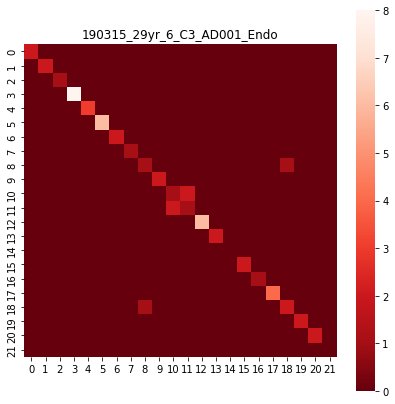

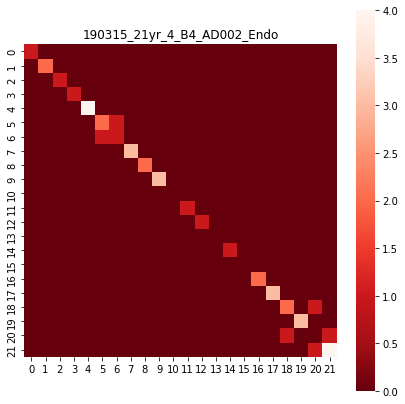

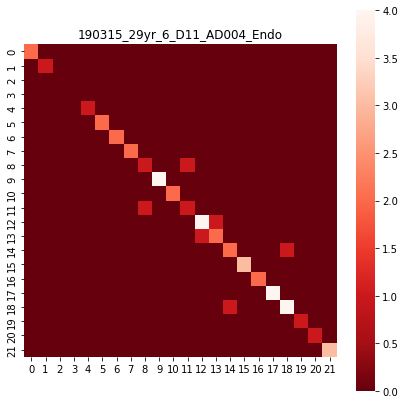

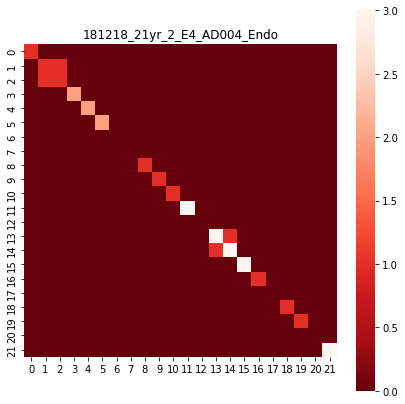

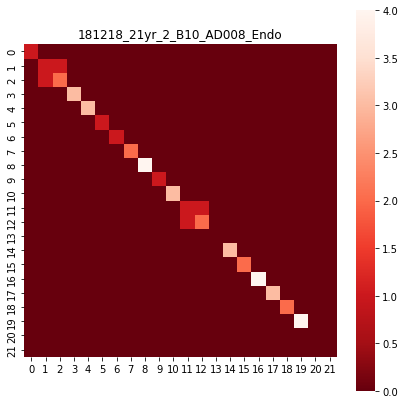

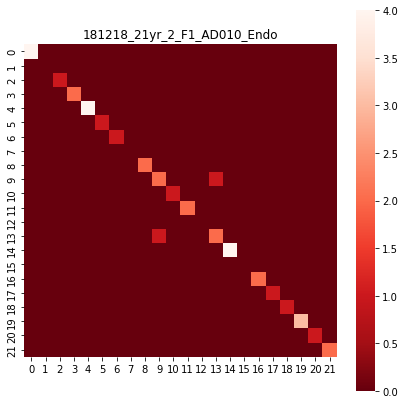

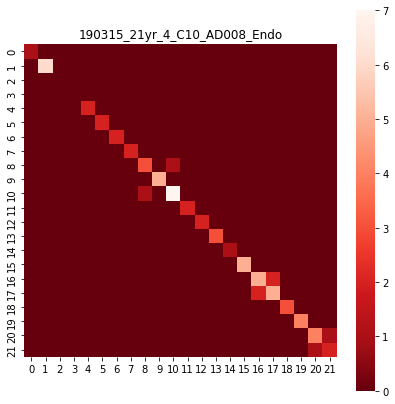

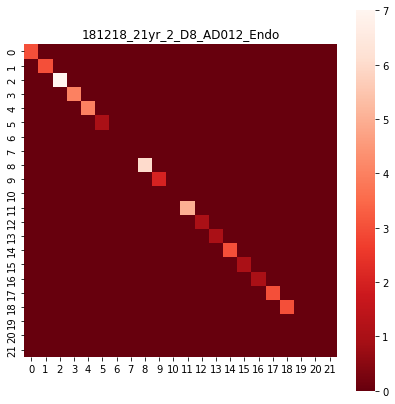

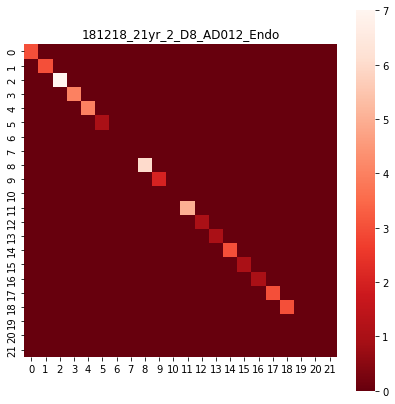

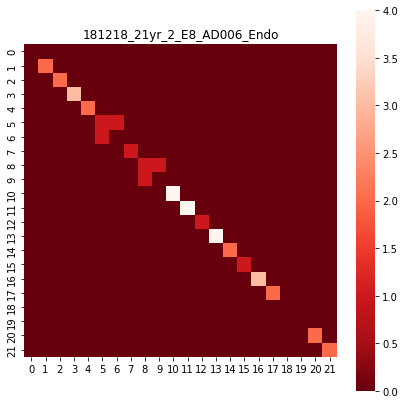

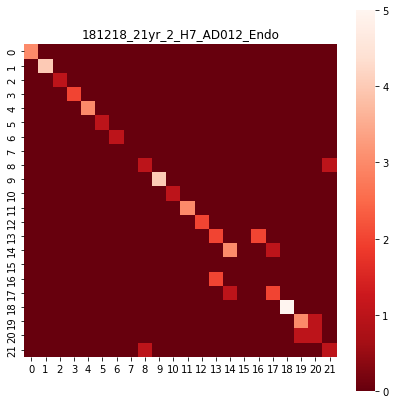

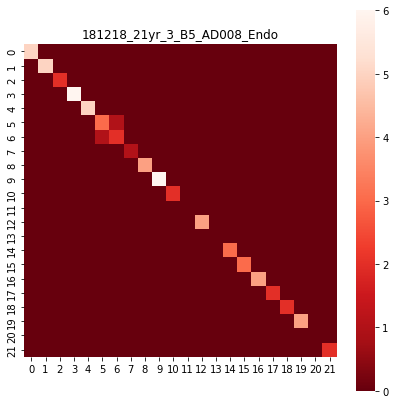

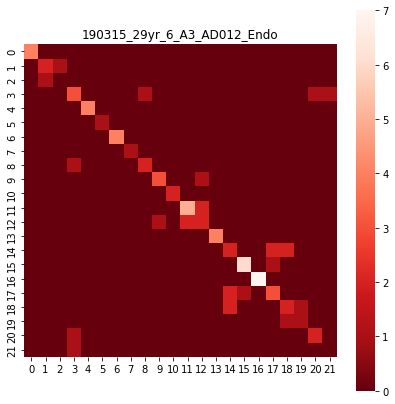

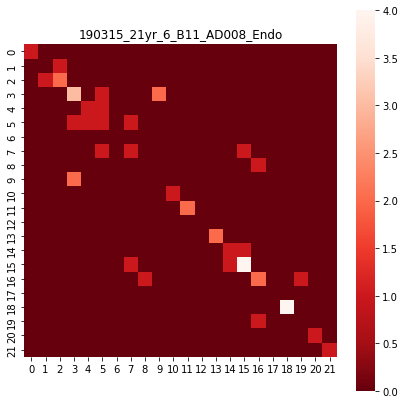

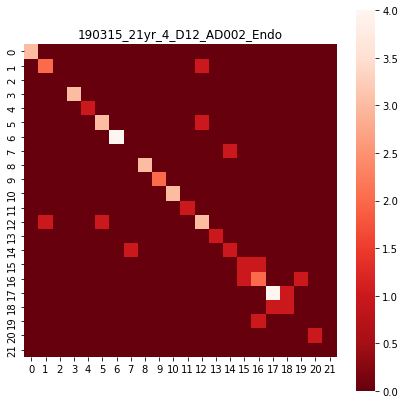

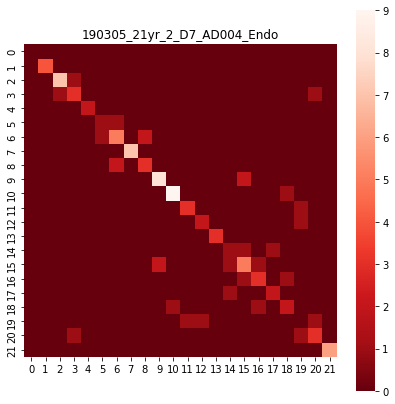

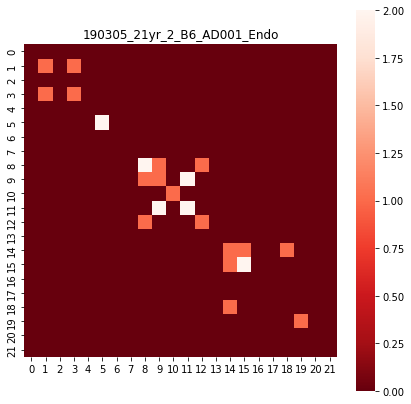

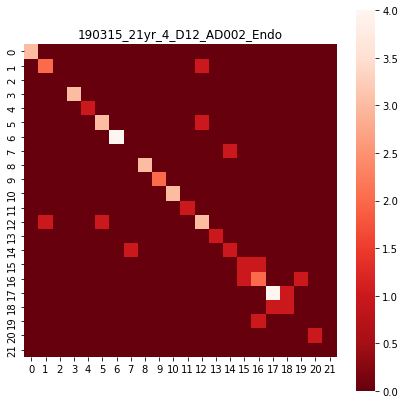

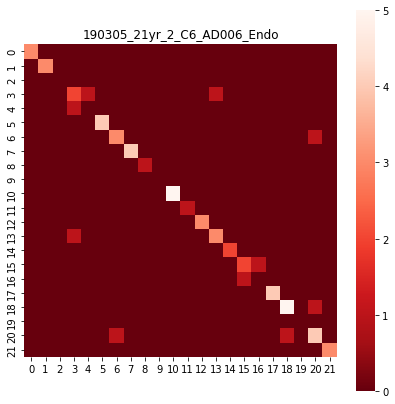

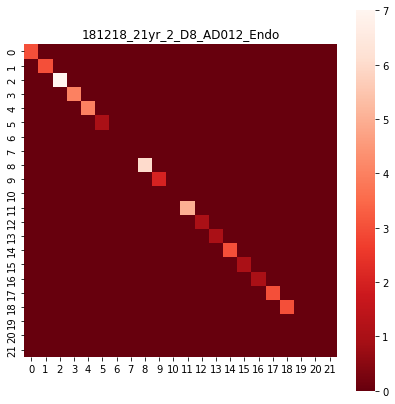

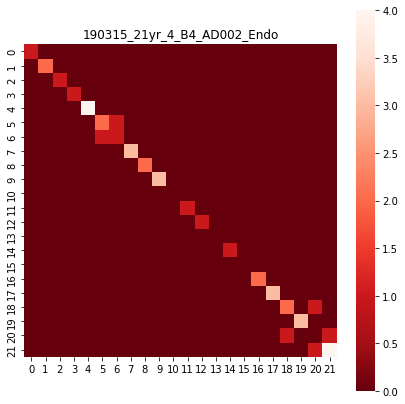

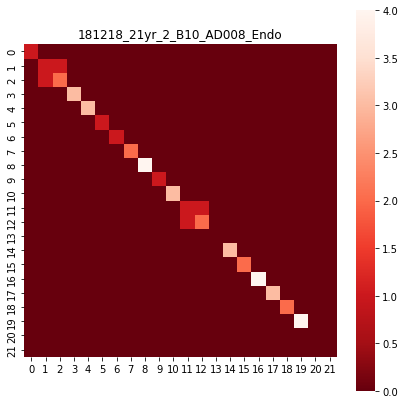

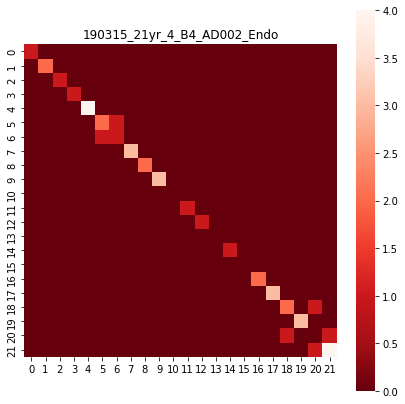

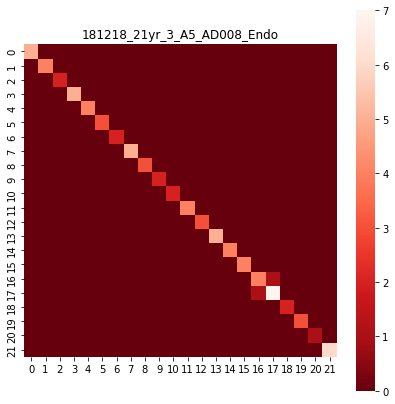

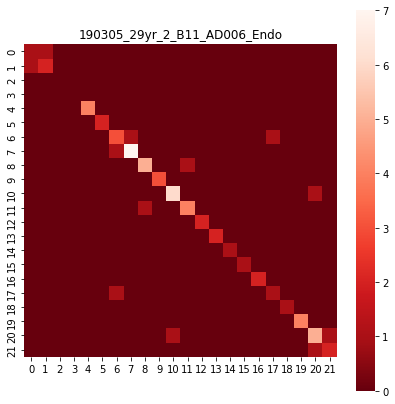

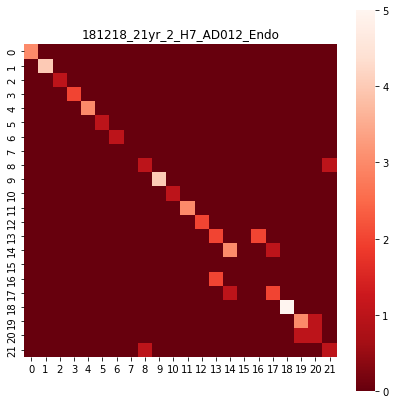

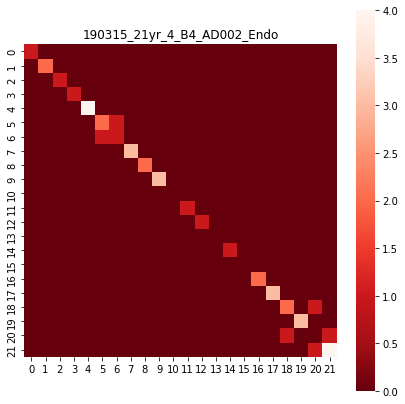

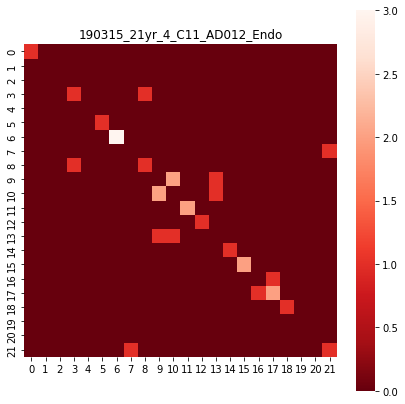

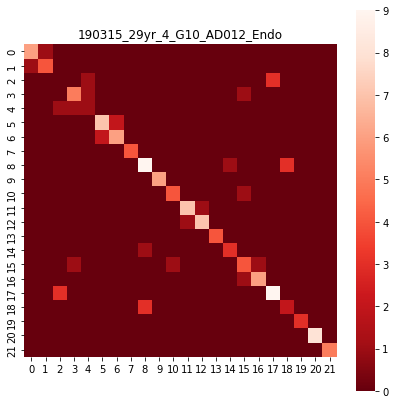

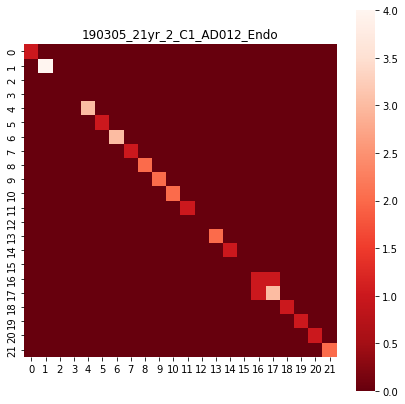

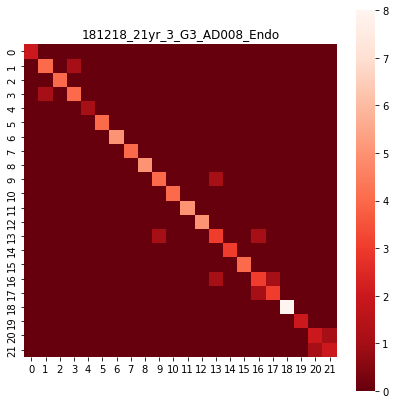

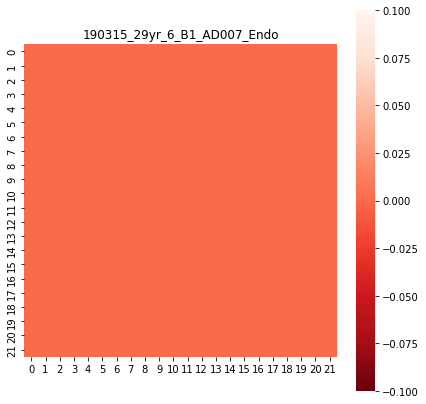

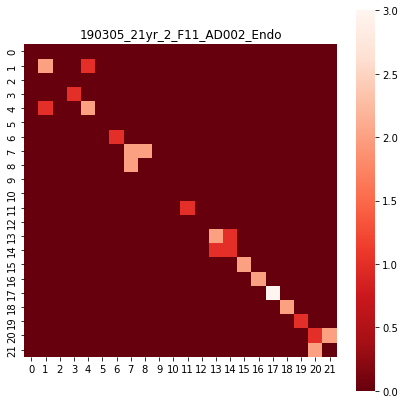

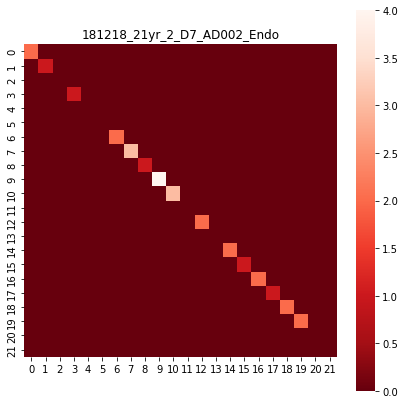

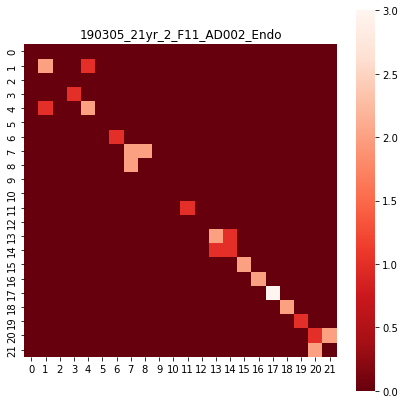

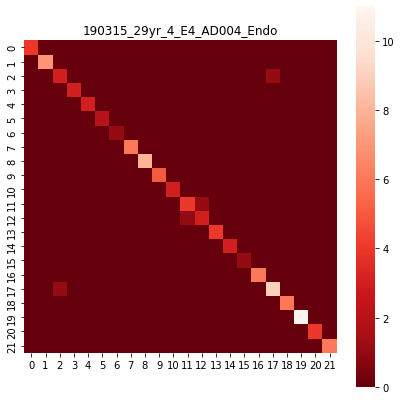

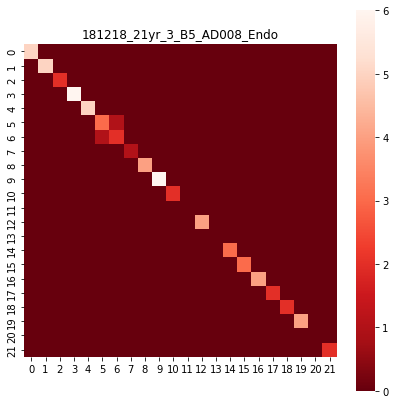

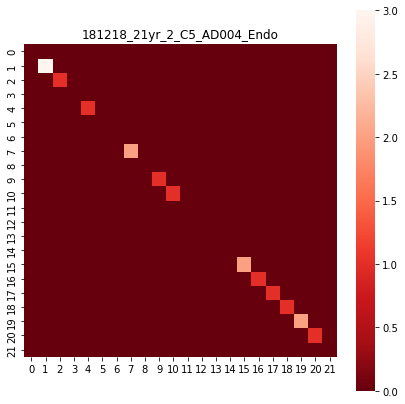

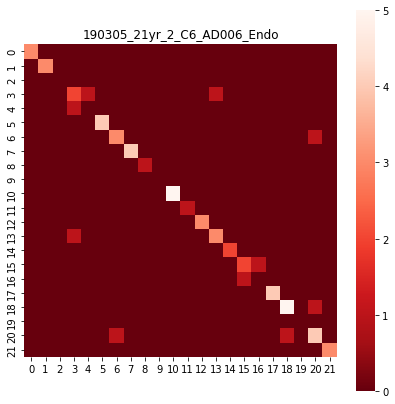

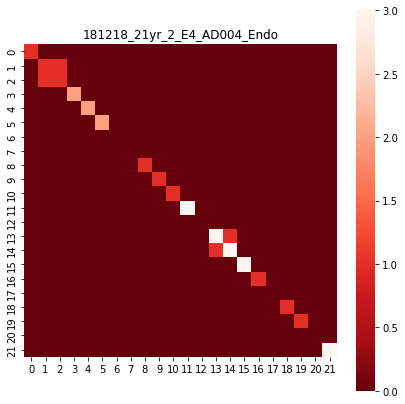

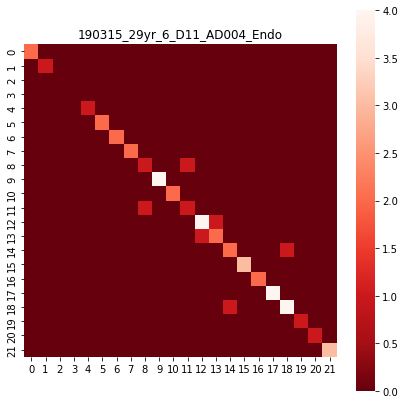

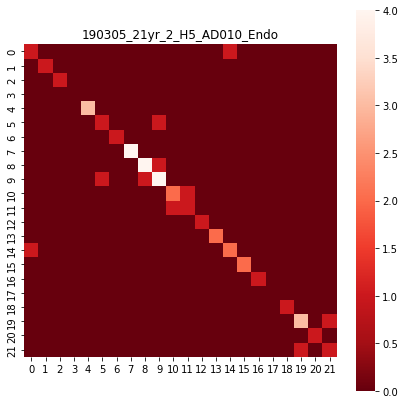

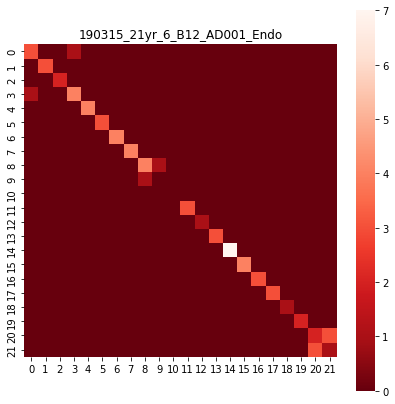

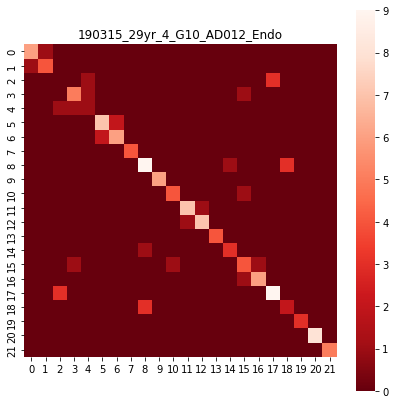

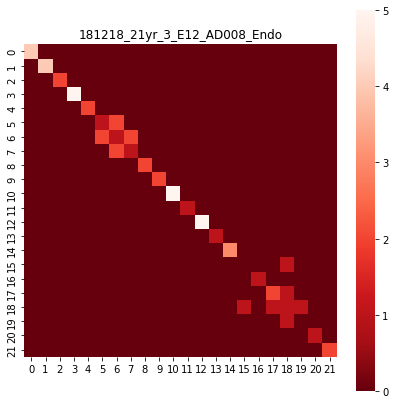

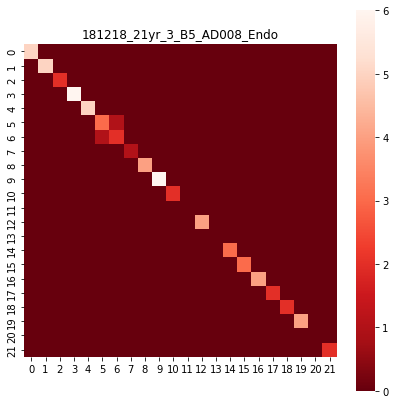

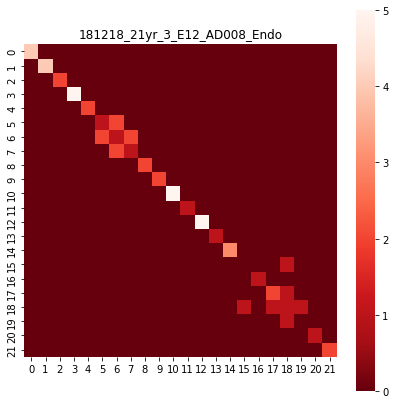

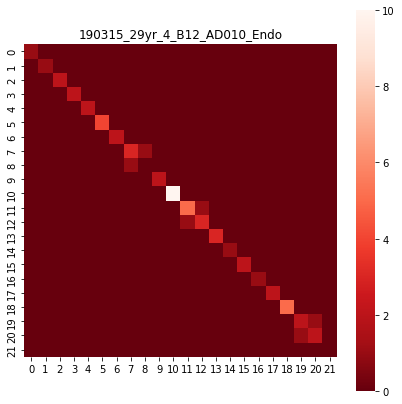

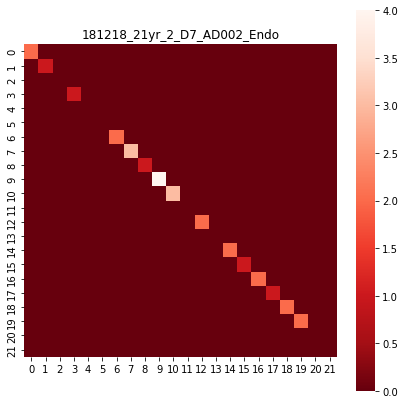

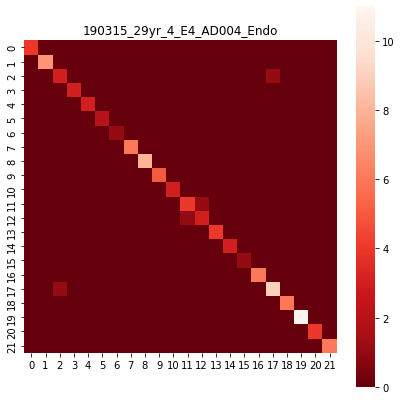

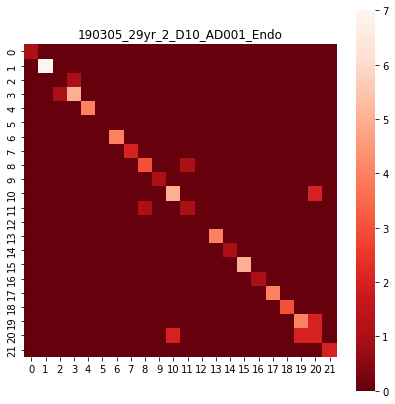

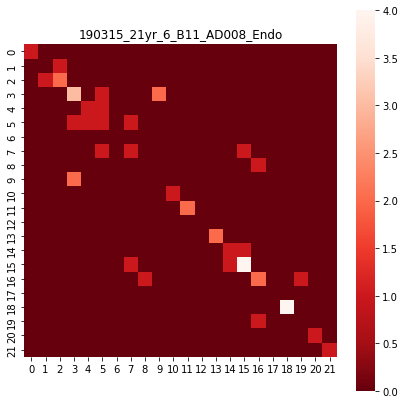

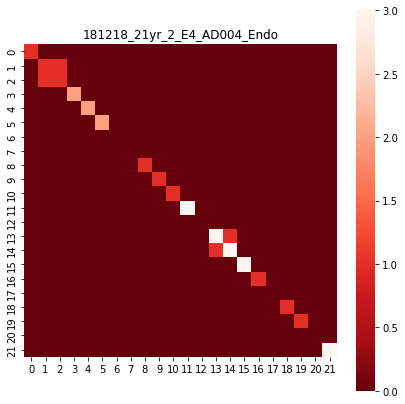

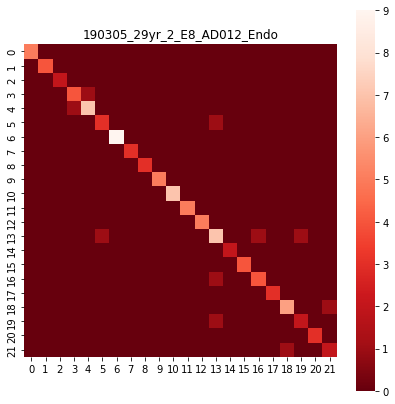

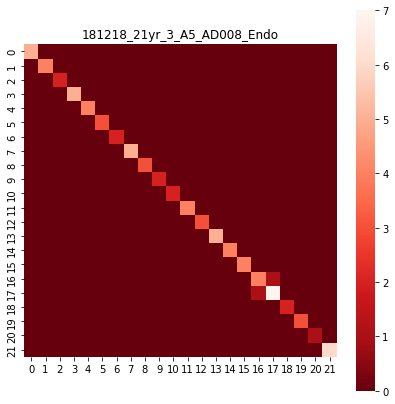

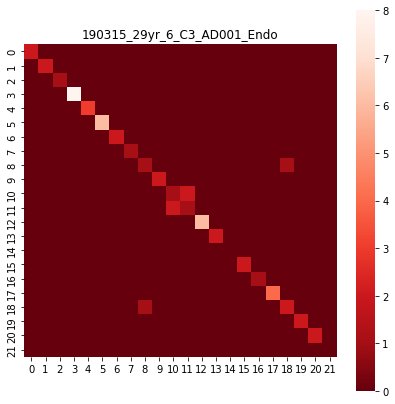

In [30]:
_loc = rna_marker_gene.loc['ABCB1']

chrom, start, end, strand = _loc['chrom'], int(_loc['chromStart']), int(_loc['chromEnd']), _loc['strand']
for i in map_info[map_info['cell_type']=='Endo']['scHiC']:
    contact, mat = catch_location('{}_10kb_contacts.cool'.format(i), chrom, start, end, strand, False)
    fig = plt.figure(figsize=[7, 7])
    ax = fig.add_subplot()
    ax.set_title(i)
    sns.heatmap(mat, cmap='Reds_r', square=True)

In [31]:
for i in map_info[map_info['cell_type']=='Endo']['scHiC']:
    print('{} {}'.format(i, rna[map_info[map_info['scHiC']==i].index, 'ABCB1'].X.reshape(-1)))

190305_21yr_2_B6_AD001_Endo [ 6. 10.]
181218_21yr_2_G1_AD012_Endo [4.]
181218_21yr_2_E4_AD004_Endo [ 7. 10. 10.  3.]
190315_21yr_6_A3_AD012_Endo [1.]
190315_21yr_6_B12_AD001_Endo [9. 2.]
190315_29yr_6_F12_AD002_Endo [17.]
181218_21yr_2_D7_AD002_Endo [14. 18.  6.]
190315_29yr_6_C3_AD001_Endo [14.  3.]
190315_21yr_4_B4_AD002_Endo [ 4. 10.  8.  3.]
190315_29yr_6_D11_AD004_Endo [ 8. 23.]
181218_21yr_2_E4_AD004_Endo [ 7. 10. 10.  3.]
181218_21yr_2_B10_AD008_Endo [16. 15.]
181218_21yr_2_F1_AD010_Endo [8.]
190315_21yr_4_C10_AD008_Endo [1.]
181218_21yr_2_D8_AD012_Endo [32.  9.  8.]
181218_21yr_2_D8_AD012_Endo [32.  9.  8.]
181218_21yr_2_E8_AD006_Endo [14.]
181218_21yr_2_H7_AD012_Endo [11.  5.]
181218_21yr_3_B5_AD008_Endo [25. 14.  5.]
190315_29yr_6_A3_AD012_Endo [16.]
190315_21yr_6_B11_AD008_Endo [12. 12.]
190315_21yr_4_D12_AD002_Endo [19.  4.]
190305_21yr_2_D7_AD004_Endo [13.]
190305_21yr_2_B6_AD001_Endo [ 6. 10.]
190315_21yr_4_D12_AD002_Endo [19.  4.]
190305_21yr_2_C6_AD006_Endo [0. 2.]
1812

In [41]:
def score(cell_type, gene_name):
    _x, _y = [], []
    for i in tqdm.tqdm(map_info[map_info['cell_type']==cell_type]['scHiC'], desc='scHiC'):
        contact, mat = catch_location('{}_10kb_contacts.cool'.format(i), chrom, start, end, strand, False)

        if not mat.sum():
            continue
        for express in rna[map_info[map_info['scHiC']==i].index, gene_name].X.reshape(-1):
            _x.append(np.diag(mat).sum()/mat.sum())
            _y.append(express)
    plt.scatter(_x, _y)
    plt.title('{} {}'.format(cell_type, gene_name))
    plt.xlabel('Diagonal signal value / All signal value')
    plt.ylabel('amount of expression')
    plt.show()

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.20it/s]


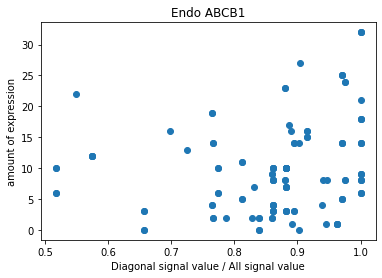

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 45.93it/s]


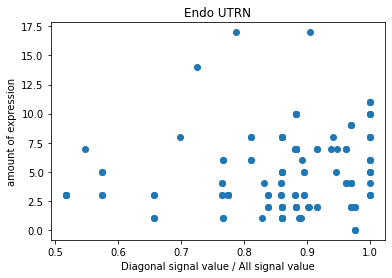

In [42]:
score('Endo', 'ABCB1')
score('Endo', 'UTRN')

scHiC: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525/525 [00:11<00:00, 46.21it/s]


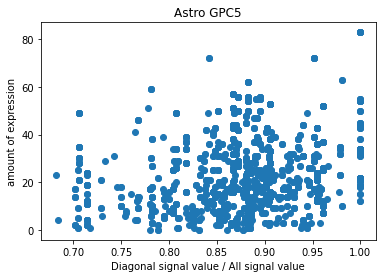

scHiC: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525/525 [00:11<00:00, 46.30it/s]


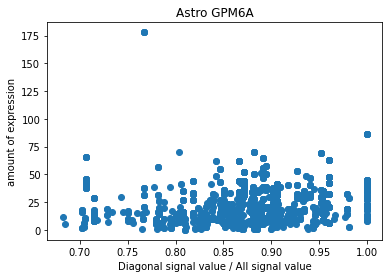

In [43]:
score('Astro', 'GPC5')
score('Astro', 'GPM6A')

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2193/2193 [00:47<00:00, 46.44it/s]


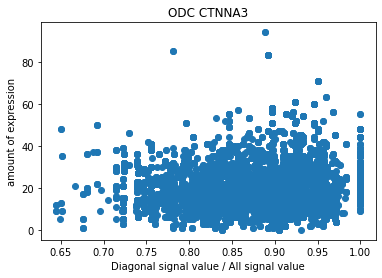

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2193/2193 [00:47<00:00, 46.46it/s]


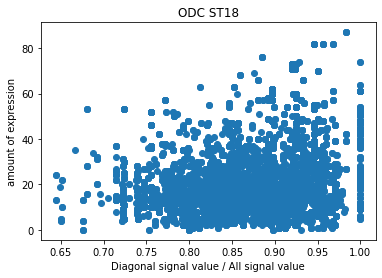

In [44]:
score('ODC', 'CTNNA3')
score('ODC', 'ST18')

In [45]:
def score(cell_type, gene_name):
    _x, _y = [], []
    for i in tqdm.tqdm(map_info[map_info['cell_type']==cell_type]['scHiC'], desc='scHiC'):
        contact, mat = catch_location('{}_10kb_contacts.cool'.format(i), chrom, start, end, strand, True)

        for express in rna[map_info[map_info['scHiC']==i].index, gene_name].X.reshape(-1):
            _x.append(np.count_nonzero(mat))
            _y.append(express)
    plt.scatter(_x, _y)
    plt.title('{} {}'.format(cell_type, gene_name))
    plt.xlabel('The number of squares outside the diagonal with signal values')
    plt.ylabel('amount of expression')
    plt.show()

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.60it/s]


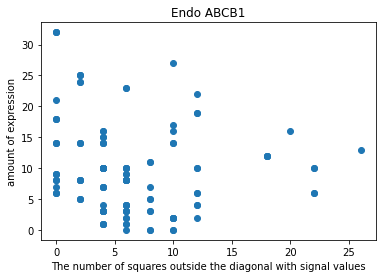

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.65it/s]


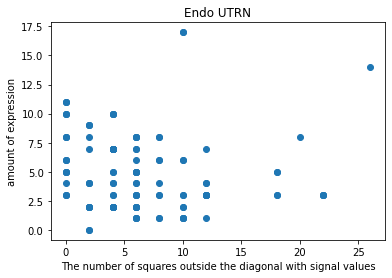

In [46]:
score('Endo', 'ABCB1')
score('Endo', 'UTRN')

scHiC: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525/525 [00:11<00:00, 46.84it/s]


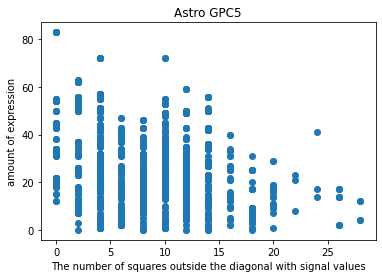

scHiC: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525/525 [00:11<00:00, 47.46it/s]


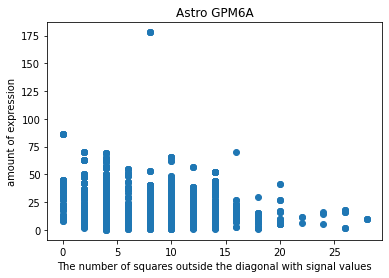

In [47]:
score('Astro', 'GPC5')
score('Astro', 'GPM6A')

In [63]:
def catch_tss_location(filename: str, chrom: str, start: int, end: int, strand: str, ignore_diag=True):
    _path = os.path.join(cools_path, filename)
    _c = cooler.Cooler(_path)
    if strand == '+'
        _loc = start - 5000
    else:
        _loc = end + 5000

    start, end = _loc - 100000, _loc + 100000
    contact = _c.matrix(balance=False, as_pixels=True, join=True).fetch('{}:{}-{}'.format(chrom, start, end))
    mat = _c.matrix(balance=False).fetch('{}:{}-{}'.format(chrom, start, end))
    
    if ignore_diag:
        np.fill_diagonal(mat, 0)
    return contact, mat

def catch_tss_locations(cell_type, chrom: str, start: int, end: int, strand: str):
    _result = None
    scHiC = map_info[map_info['cell_type']==cell_type]['scHiC'][:60]
    for i in tqdm.tqdm(scHiC, desc='scHiC'):
        contact, mat = catch_tss_location('{}_10kb_contacts.cool'.format(i), chrom, start, end, strand)
        _result = _result + mat if _result is not None else mat
    _result = _result / len(scHiC)

    
    fig = plt.figure(figsize=[7, 7])
    ax = fig.add_subplot()
    ax.set_title('{}:{}-{}.{}.{}'.format(chrom, start, end, strand, cell_type))
    sns.heatmap(_result, cmap='Reds_r', square=True)
    return

def test_tss(gene_name):
    _loc = rna_marker_gene.loc[gene_name]
    print(_loc)
    for cell_type in ['Astro', 'Endo', 'ODC', 'OPC']:
        catch_tss_locations(cell_type, _loc['chrom'], int(_loc['chromStart']), int(_loc['chromEnd']), _loc['strand'])
        
def score_tss(cell_type, gene_name):
    _x, _y = [], []
    for i in tqdm.tqdm(map_info[map_info['cell_type']==cell_type]['scHiC'], desc='scHiC'):
        contact, mat = catch_tss_location('{}_10kb_contacts.cool'.format(i), chrom, start, end, strand, False)

        if not mat.sum():
            continue
        for express in rna[map_info[map_info['scHiC']==i].index, gene_name].X.reshape(-1):
            _x.append(np.diag(mat).sum()/mat.sum())
            _y.append(express)
    plt.scatter(_x, _y)
    plt.title('{} {}'.format(cell_type, gene_name))
    plt.xlabel('Diagonal signal value / All signal value')
    plt.ylabel('amount of expression')
    plt.show()

rank          ['Astro_0']
chrom               chr13
chromStart     92050928.0
chromEnd       93519490.0
strand                  +
Name: GPC5, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 51.42it/s]


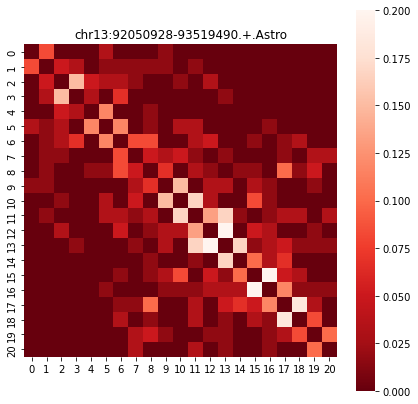

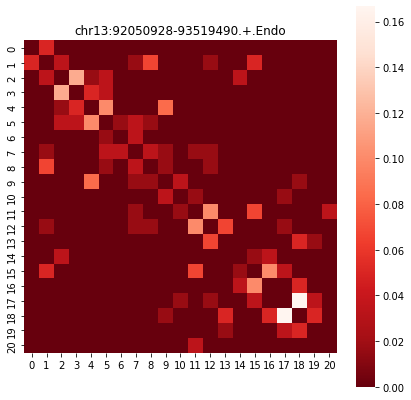

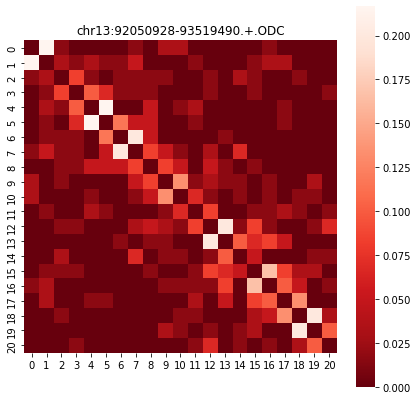

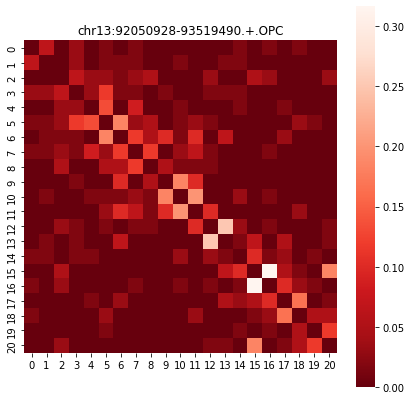

In [64]:
test_tss('GPC5')

rank          ['Astro_1', 'Sst_42', 'OPC_56']
chrom                                    chr4
chromStart                        176554084.0
chromEnd                          176923815.0
strand                                      -
Name: GPM6A, dtype: object


scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.30it/s]


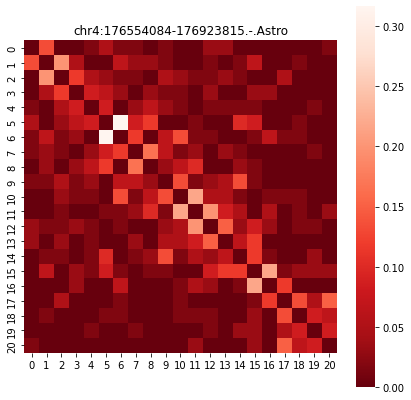

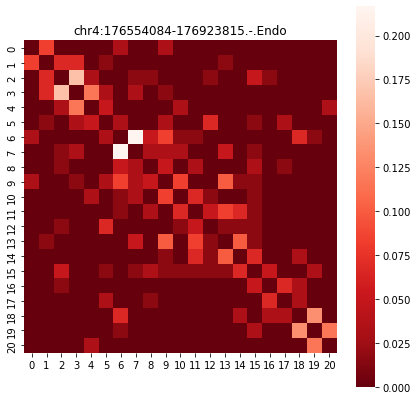

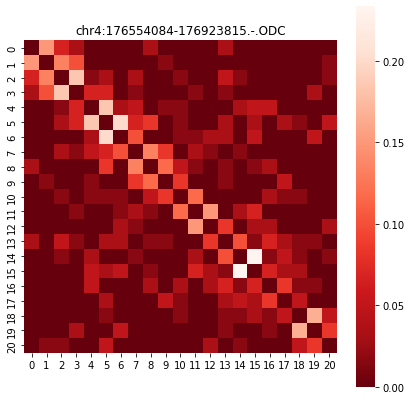

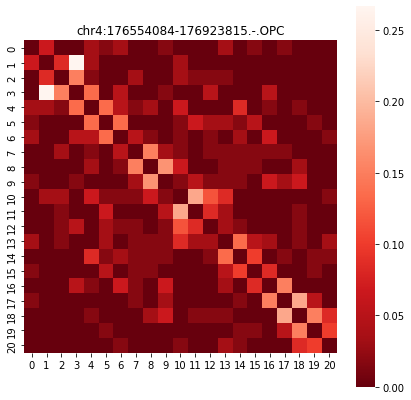

In [65]:
test_tss('GPM6A')

scHiC: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525/525 [00:11<00:00, 47.34it/s]


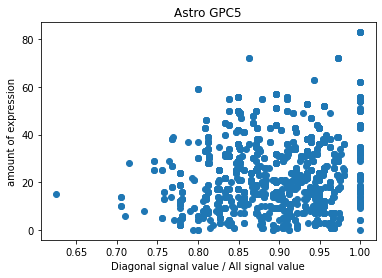

scHiC: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525/525 [00:11<00:00, 47.34it/s]


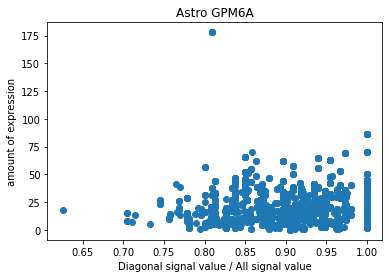

In [66]:
score_tss('Astro', 'GPC5')
score_tss('Astro', 'GPM6A')

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.17it/s]


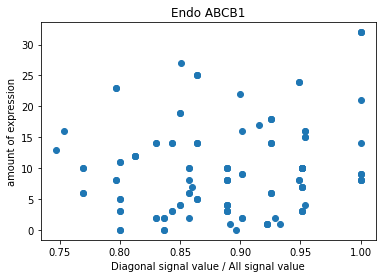

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.46it/s]


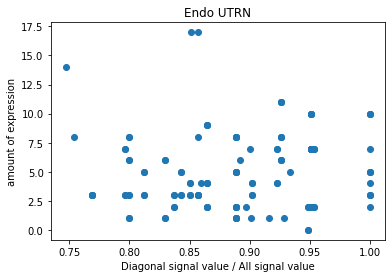

In [67]:
score_tss('Endo', 'ABCB1')
score_tss('Endo', 'UTRN')

In [68]:
def score_tss(cell_type, gene_name):
    _x, _y = [], []
    for i in tqdm.tqdm(map_info[map_info['cell_type']==cell_type]['scHiC'], desc='scHiC'):
        contact, mat = catch_tss_location('{}_10kb_contacts.cool'.format(i), chrom, start, end, strand, True)

        for express in rna[map_info[map_info['scHiC']==i].index, gene_name].X.reshape(-1):
            _x.append(np.count_nonzero(mat))
            _y.append(express)
    plt.scatter(_x, _y)
    plt.title('{} {}'.format(cell_type, gene_name))
    plt.xlabel('The number of squares outside the diagonal with signal values')
    plt.ylabel('amount of expression')
    plt.show()

scHiC: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525/525 [00:11<00:00, 46.05it/s]


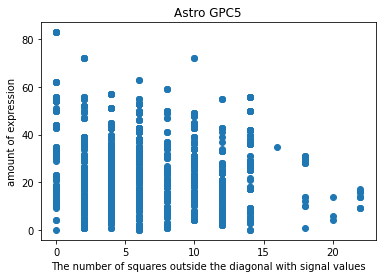

scHiC: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525/525 [00:11<00:00, 46.20it/s]


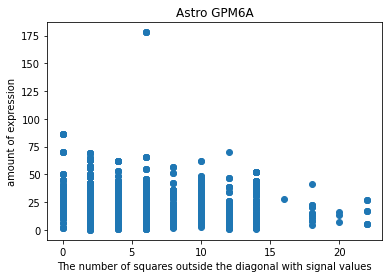

In [69]:
score_tss('Astro', 'GPC5')
score_tss('Astro', 'GPM6A')

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.85it/s]


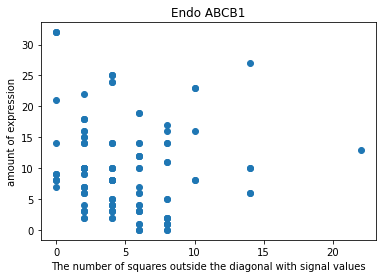

scHiC: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 46.85it/s]


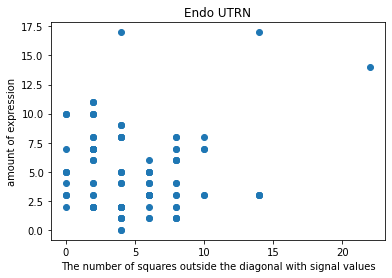

In [70]:
score_tss('Endo', 'ABCB1')
score_tss('Endo', 'UTRN')